In [13]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [88]:
df = pd.read_csv("/Users/Ronjamac/Downloads/Ronja_Lappe/VNM_annual_coastlinesnewdatabase.csv",sep=";",decimal=",")
geometry = [Point(xy) for xy in zip(df.Intersect_lon, df.Intersect_lat)]
df = df.drop(['Intersect_lon', 'Intersect_lat'], axis=1)
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
gdf.to_file("/Users/Ronjamac/Downloads/Ronja_Lappe/VNM_annual_coastlinesnewdatabase.geojson",driver="GeoJSON")

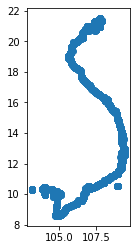

In [87]:
gdf.plot()